<a href="https://colab.research.google.com/github/costpetrides/Temperature_Forecasting_MethodComparison/blob/main/RFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)


df = pd.read_csv("/content/Athens_meteo.csv",
                 parse_dates=['DAY'],  # change to date time format
                 index_col="DAY")

df = df[['T_mean', 'RH_max', 'RH_mean', 'RH_min', 'P_max','P_mean', 'P_min', 'Rain', 'U', 'U_max']]

df.head()

,T_mean,RH_max,RH_mean,RH_min,P_max,P_mean,P_min,Rain,U,U_max
DAY,,,,,,,,,,
2010-01-01,18.100,61.400,91,33,1003.600,1006.300,1002.000,0.200,4.000,12.700
2010-01-02,15.700,57.400,70,45,1005.200,1008.700,1001.500,0.000,6.800,20.700
2010-01-03,13.600,56.000,76,39,1011.700,1016.700,1008.600,0.000,5.000,15.400
2010-01-04,9.600,50.700,60,38,1021.300,1023.100,1016.800,0.000,4.300,11.000
2010-01-05,13.500,70.500,82,54,1018.700,1022.100,1015.500,0.000,7.900,19.800


Random Forest Evaluation on Test Set
MAE       : 0.95 °C
RMSE      : 1.30 °C
R² Score  : 0.966


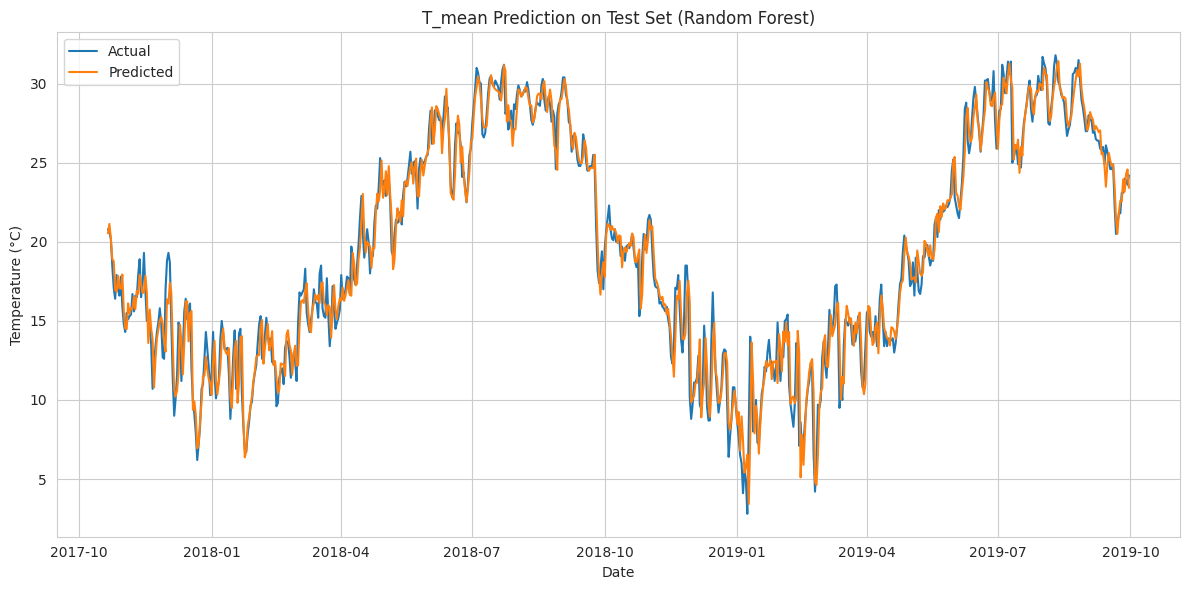

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# Step 1: Add seasonal features
df['dayofyear'] = df.index.dayofyear
df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365.0)

# ─────────────────────────────────────────────────────────────
# Step 2: Create lag features for T_mean
window = 14  # number of past days to use
for lag in range(1, window + 1):
    df[f'T_mean_lag{lag}'] = df['T_mean'].shift(lag)

# ─────────────────────────────────────────────────────────────
# Step 3: Drop rows with NaNs caused by lagging
df.dropna(inplace=True)

# ─────────────────────────────────────────────────────────────
# Step 4: Define features and target
lag_features = [f'T_mean_lag{i}' for i in range(1, window + 1)]
static_features = ['RH_mean', 'P_mean', 'Rain', 'U', 'sin_doy', 'cos_doy']
features = lag_features + static_features
target = 'T_mean'

X = df[features].values
y = df[target].values

# ─────────────────────────────────────────────────────────────
# Step 5: Chronological train/test split (80/20)
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
dates_test = df.index[split_index:]

# ─────────────────────────────────────────────────────────────
# Step 6: Fit Random Forest Regressor
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# ─────────────────────────────────────────────────────────────
# Step 7: Predict and Evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("="*40)
print("Random Forest Evaluation on Test Set")
print("="*40)
print(f"MAE       : {mae:.2f} °C")
print(f"RMSE      : {rmse:.2f} °C")
print(f"R² Score  : {r2:.3f}")
print("="*40)

# ─────────────────────────────────────────────────────────────
# Step 8: Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual')
plt.plot(dates_test, y_pred, label='Predicted')
plt.title('T_mean Prediction on Test Set (Random Forest)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
